# Interval Tree: Construction & Query Visualization

An **Interval Tree** is a balanced binary search tree used to efficiently find all intervals that overlap with a given query interval or point.

**Key ideas:**
- Given a set of intervals $[s_i, e_i]$, sort them by their start points $s_i$.
- Recursively pick the **median** interval as the root to build a balanced BST.
- Each node stores an additional value **max_end** — the maximum right endpoint in its subtree — enabling efficient pruning during queries.

**Time complexity:**
- Construction: $O(n \log n)$
- Query (report $k$ overlapping intervals): $O(\log n + k)$

This notebook walks through the full construction process step by step.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

## Step 1: Generate Random Intervals

We start by generating a set of random intervals $[s_i, e_i]$ where $0 \le s_i < e_i \le 100$.

In [11]:
#generate random intervals
random_intervals = np.random.randint(0, 100, (10, 2))
random_intervals.sort(axis=1)  # Ensure start < end
print("Random Intervals:\n", random_intervals)

Random Intervals:
 [[15 47]
 [28 73]
 [41 73]
 [27 96]
 [ 1 81]
 [ 0 46]
 [82 97]
 [ 1 15]
 [10 57]
 [ 2 84]]


### Visualize the raw intervals

Each horizontal bar represents an interval $[s_i, e_i]$. The x-axis shows the value range.

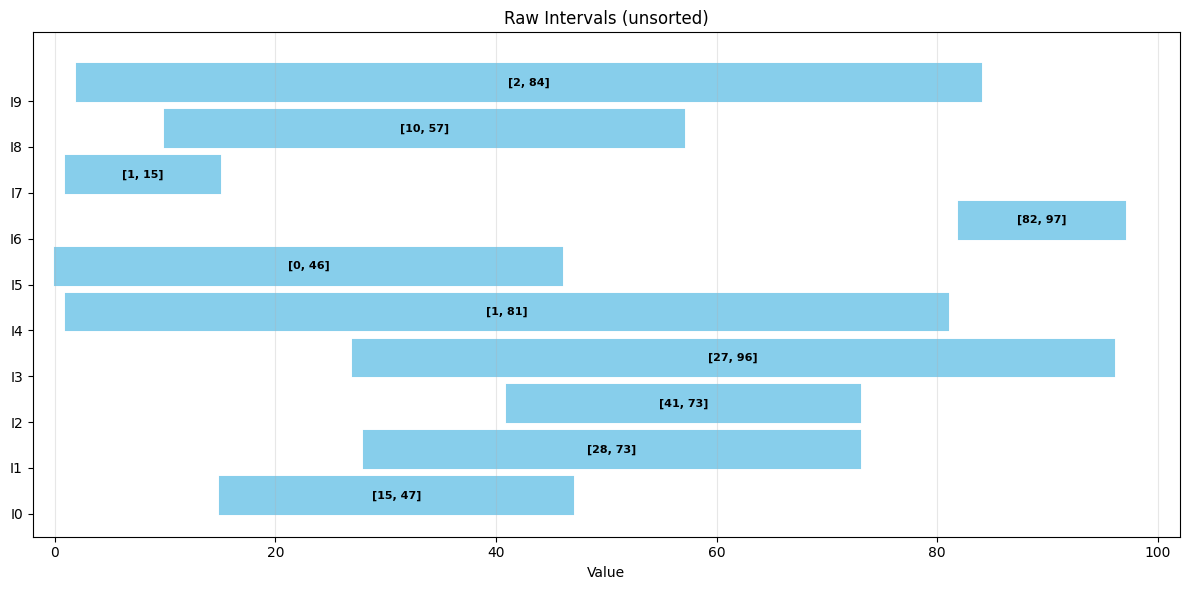

In [12]:
#plot intervals
fig, ax = plt.subplots(figsize=(12, 6))
for i, (start, end) in enumerate(random_intervals):
    ax.add_patch(patches.Rectangle((start, i), end - start, 0.8, color='skyblue', edgecolor='steelblue', linewidth=1.5))
    ax.text((start + end) / 2, i + 0.4, f'[{start}, {end}]', ha='center', va='center', fontsize=8, fontweight='bold')
ax.set_xlim(-2, 102)
ax.set_ylim(-0.5, len(random_intervals) + 0.5)
ax.set_yticks(range(len(random_intervals)))
ax.set_yticklabels([f'I{i}' for i in range(len(random_intervals))])
ax.set_xlabel('Value')
ax.set_title('Raw Intervals (unsorted)')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Step 2: Sort Intervals by Start Point

Before building the tree, we sort all intervals by their **left endpoint** $s_i$. This ensures that the median-based split produces a balanced BST over the intervals.

Sorted Intervals:
  I0: [0, 46]
  I1: [1, 81]
  I2: [1, 15]
  I3: [2, 84]
  I4: [10, 57]
  I5: [15, 47]
  I6: [27, 96]
  I7: [28, 73]
  I8: [41, 73]
  I9: [82, 97]


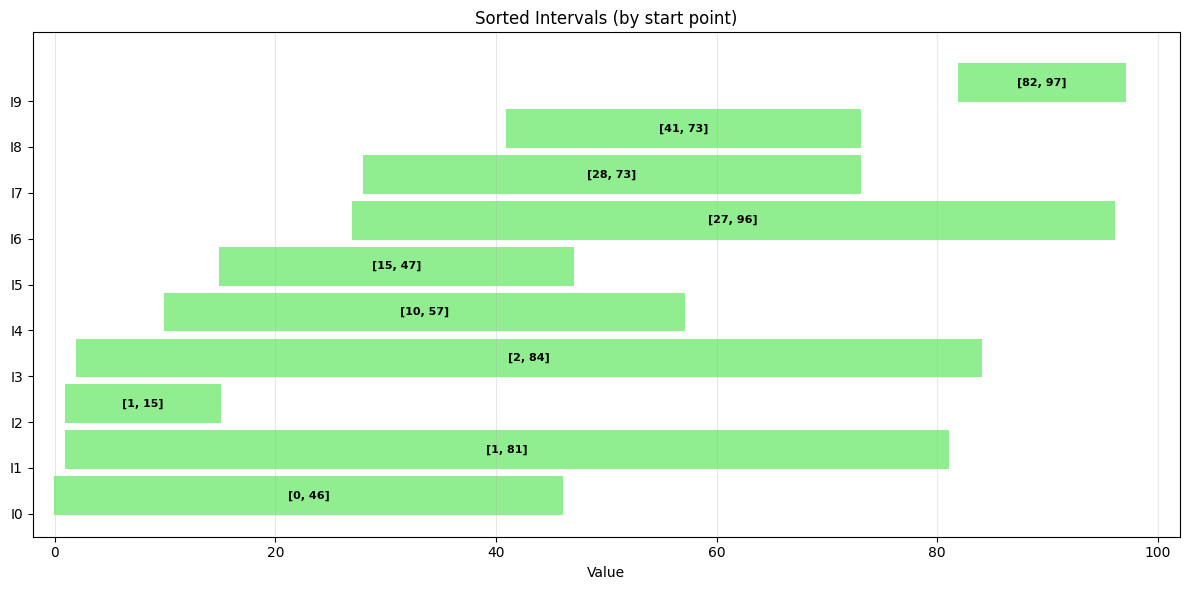

In [13]:
# Sort intervals by start point
intervals = random_intervals.tolist()
intervals.sort(key=lambda x: x[0])
print("Sorted Intervals:")
for i, (s, e) in enumerate(intervals):
    print(f"  I{i}: [{s}, {e}]")

# Visualize sorted intervals
fig, ax = plt.subplots(figsize=(12, 6))
for i, (start, end) in enumerate(intervals):
    ax.add_patch(patches.Rectangle((start, i), end - start, 0.8, color='lightgreen', edgecolor='seagreen', linewidth=1.5))
    ax.text((start + end) / 2, i + 0.4, f'[{start}, {end}]', ha='center', va='center', fontsize=8, fontweight='bold')
ax.set_xlim(-2, 102)
ax.set_ylim(-0.5, len(intervals) + 0.5)
ax.set_yticks(range(len(intervals)))
ax.set_yticklabels([f'I{i}' for i in range(len(intervals))])
ax.set_xlabel('Value')
ax.set_title('Sorted Intervals (by start point)')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Step 3: Build the Interval Tree

### Algorithm

Given the sorted list of intervals, we recursively build a balanced BST:

1. Pick the **median** interval as the current node.
2. Recursively build the **left** subtree from intervals before the median.
3. Recursively build the **right** subtree from intervals after the median.
4. Compute **max_end** for each node:

$$\text{max\_end}(v) = \max\bigl(e_v,\; \text{max\_end}(\text{left}(v)),\; \text{max\_end}(\text{right}(v))\bigr)$$

The `max_end` value allows us to **prune** entire subtrees during queries — if a subtree's `max_end` is less than the query's start, no interval in that subtree can overlap.

In [14]:
# Interval Tree Node
class IntervalNode:
    def __init__(self, interval):
        self.interval = interval      # [start, end]
        self.max_end = interval[1]     # max right endpoint in this subtree
        self.left = None
        self.right = None

def build_interval_tree(intervals, depth=0, log=None):
    """Recursively build a balanced interval tree from sorted intervals."""
    if not intervals:
        return None
    mid = len(intervals) // 2
    node = IntervalNode(intervals[mid])
    
    if log is not None:
        log.append({
            'action': 'create',
            'interval': intervals[mid],
            'depth': depth,
            'all_intervals': [iv for iv in intervals],
            'mid_index': mid
        })
    
    node.left = build_interval_tree(intervals[:mid], depth + 1, log)
    node.right = build_interval_tree(intervals[mid + 1:], depth + 1, log)
    
    # Propagate max_end upward
    node.max_end = max(
        node.interval[1],
        node.left.max_end if node.left else float('-inf'),
        node.right.max_end if node.right else float('-inf')
    )
    
    if log is not None:
        log.append({
            'action': 'update_max',
            'interval': node.interval,
            'max_end': node.max_end,
            'depth': depth
        })
    
    return node

# Build tree with construction log
construction_log = []
root = build_interval_tree(intervals, log=construction_log)
print(f"Tree built with {len(intervals)} intervals.")
print(f"Root: {root.interval}, max_end = {root.max_end}")
print(f"\nConstruction steps recorded: {len(construction_log)}")

Tree built with 10 intervals.
Root: [15, 47], max_end = 97

Construction steps recorded: 20


## Step 4: Visualize the Tree Structure

Below we draw the interval tree as a binary tree. Each node shows:
- The interval $[s, e]$
- The **max_end** value (in red) — the maximum right endpoint in the entire subtree

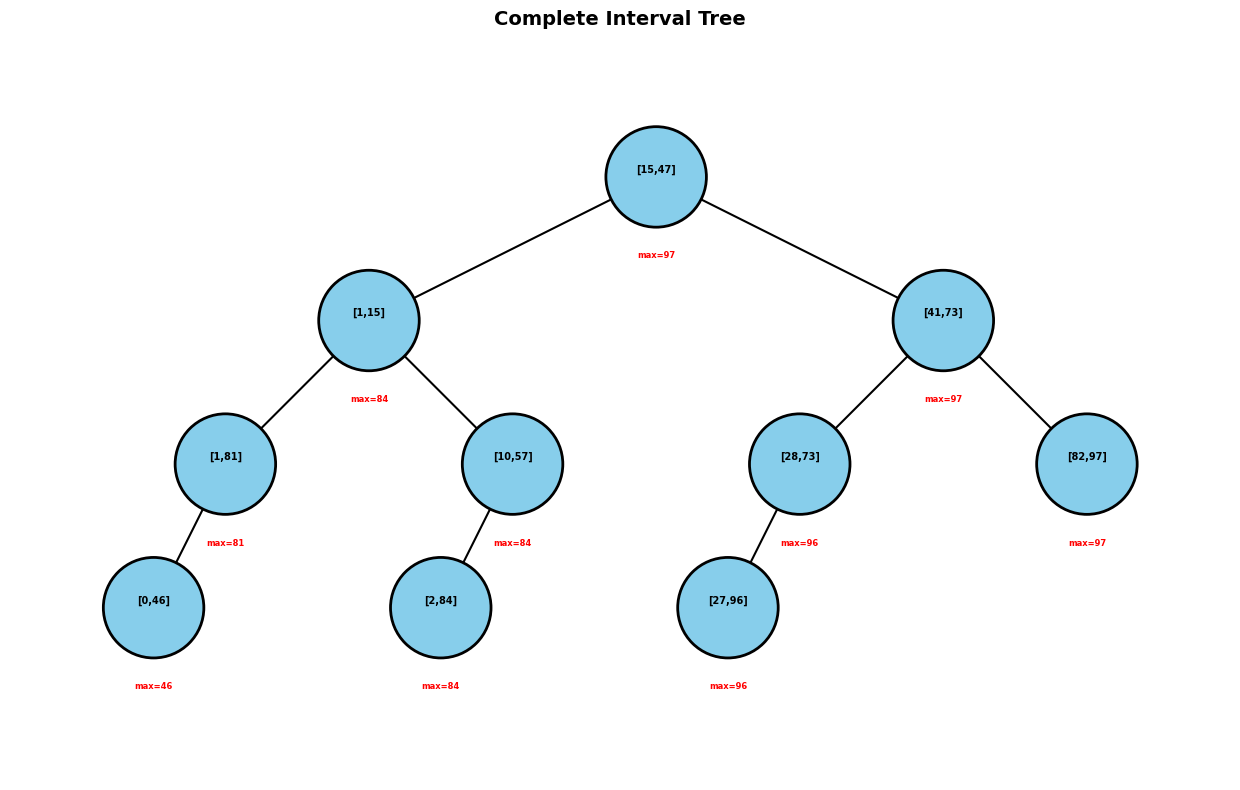

In [15]:
def compute_tree_positions(node, x=0, y=0, dx=1.0, positions=None):
    """Assign (x, y) positions to each node for plotting."""
    if positions is None:
        positions = {}
    if node is None:
        return positions
    positions[id(node)] = (x, y, node)
    compute_tree_positions(node.left, x - dx, y - 1, dx / 2, positions)
    compute_tree_positions(node.right, x + dx, y - 1, dx / 2, positions)
    return positions

def draw_tree(root, ax, highlight_nodes=None, title='Interval Tree'):
    """Draw the interval tree as a visual binary tree."""
    positions = compute_tree_positions(root, x=0, y=0, dx=2.0)
    if highlight_nodes is None:
        highlight_nodes = set()
    
    # Draw edges first
    for nid, (x, y, node) in positions.items():
        if node.left and id(node.left) in positions:
            cx, cy, _ = positions[id(node.left)]
            ax.plot([x, cx], [y, cy], 'k-', linewidth=1.5, zorder=1)
        if node.right and id(node.right) in positions:
            cx, cy, _ = positions[id(node.right)]
            ax.plot([x, cx], [y, cy], 'k-', linewidth=1.5, zorder=1)
    
    # Draw nodes
    for nid, (x, y, node) in positions.items():
        color = '#FFD700' if nid in highlight_nodes else '#87CEEB'
        circle = plt.Circle((x, y), 0.35, color=color, ec='black', linewidth=2, zorder=2)
        ax.add_patch(circle)
        ax.text(x, y + 0.05, f'[{node.interval[0]},{node.interval[1]}]',
                ha='center', va='center', fontsize=7, fontweight='bold', zorder=3)
        ax.text(x, y - 0.55, f'max={node.max_end}',
                ha='center', va='center', fontsize=6, color='red', fontweight='bold', zorder=3)
    
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')

# Draw the complete interval tree
fig, ax = plt.subplots(figsize=(14, 8))
draw_tree(root, ax, title='Complete Interval Tree')
# Auto-fit
positions = compute_tree_positions(root, x=0, y=0, dx=2.0)
xs = [p[0] for p in positions.values()]
ys = [p[1] for p in positions.values()]
ax.set_xlim(min(xs) - 1, max(xs) + 1)
ax.set_ylim(min(ys) - 1.2, max(ys) + 1)
plt.tight_layout()
plt.show()

## Step 5: Step-by-Step Construction

The animation below shows how the interval tree is built incrementally:

1. **Node creation** (blue): The median interval is selected and a node is created.
2. **max_end propagation** (gold → blue): After both children are built, `max_end` is computed and propagated upward.

Watch how the tree grows from the root down, then `max_end` values ripple back up from leaves to root.

In [16]:
def build_tree_snapshots(intervals):
    """Build the tree step-by-step, returning a snapshot after each node creation."""
    snapshots = []
    
    class TreeBuilder:
        def __init__(self):
            self.nodes = {}   # id -> (interval, max_end, left_id, right_id)
            self.positions = {}  # id -> (x, y)
            self.highlight = None
            self.step_desc = ""
            self.node_counter = 0
        
        def build(self, ivs, x=0, y=0, dx=2.0):
            if not ivs:
                return None
            mid = len(ivs) // 2
            nid = self.node_counter
            self.node_counter += 1
            
            self.nodes[nid] = {'interval': ivs[mid], 'max_end': ivs[mid][1], 'left': None, 'right': None}
            self.positions[nid] = (x, y)
            self.highlight = nid
            self.step_desc = f"Create node [{ivs[mid][0]}, {ivs[mid][1]}]"
            snapshots.append(self._snapshot())
            
            left_id = self.build(ivs[:mid], x - dx, y - 1, dx / 2)
            right_id = self.build(ivs[mid+1:], x + dx, y - 1, dx / 2)
            
            self.nodes[nid]['left'] = left_id
            self.nodes[nid]['right'] = right_id
            
            # Update max_end
            max_e = ivs[mid][1]
            if left_id is not None:
                max_e = max(max_e, self.nodes[left_id]['max_end'])
            if right_id is not None:
                max_e = max(max_e, self.nodes[right_id]['max_end'])
            self.nodes[nid]['max_end'] = max_e
            self.highlight = nid
            self.step_desc = f"Update max_end of [{ivs[mid][0]}, {ivs[mid][1]}] → {max_e}"
            snapshots.append(self._snapshot())
            
            return nid
        
        def _snapshot(self):
            import copy
            return {
                'nodes': copy.deepcopy(self.nodes),
                'positions': copy.deepcopy(self.positions),
                'highlight': self.highlight,
                'step_desc': self.step_desc
            }
    
    builder = TreeBuilder()
    builder.build(intervals)
    return snapshots

snapshots = build_tree_snapshots(intervals)

def draw_snapshot(ax, snap):
    ax.clear()
    nodes = snap['nodes']
    positions = snap['positions']
    highlight = snap['highlight']
    
    # Draw edges
    for nid, info in nodes.items():
        x, y = positions[nid]
        for child_id in [info['left'], info['right']]:
            if child_id is not None and child_id in positions:
                cx, cy = positions[child_id]
                ax.plot([x, cx], [y, cy], 'k-', linewidth=1.5, zorder=1)
    
    # Draw nodes
    for nid, info in nodes.items():
        x, y = positions[nid]
        color = '#FFD700' if nid == highlight else '#87CEEB'
        circle = plt.Circle((x, y), 0.35, color=color, ec='black', linewidth=2, zorder=2)
        ax.add_patch(circle)
        iv = info['interval']
        ax.text(x, y + 0.05, f'[{iv[0]},{iv[1]}]',
                ha='center', va='center', fontsize=7, fontweight='bold', zorder=3)
        ax.text(x, y - 0.55, f'max={info["max_end"]}',
                ha='center', va='center', fontsize=6, color='red', fontweight='bold', zorder=3)
    
    ax.set_title(snap['step_desc'], fontsize=12, fontweight='bold')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5.5, 1.5)
    ax.set_aspect('equal')
    ax.axis('off')

# Create animation
fig, ax = plt.subplots(figsize=(14, 8))

def animate(frame):
    draw_snapshot(ax, snapshots[frame])

ani = FuncAnimation(fig, animate, frames=len(snapshots), interval=1200, repeat=False)
plt.close(fig)
HTML(ani.to_jshtml())

## Step 6: Query the Interval Tree

Given a query interval $[q_s, q_e]$, we find all stored intervals that **overlap** with it. Two intervals overlap when:

$$s_i \le q_e \quad \text{and} \quad e_i \ge q_s$$

The `max_end` field lets us skip entire subtrees: if `max_end(left) < q_s`, no interval in the left subtree can overlap.

In [17]:
def query_interval_tree(node, query):
    """Find all intervals overlapping with the query interval [qs, qe]."""
    if not node:
        return []
    result = []
    if node.interval[0] <= query[1] and node.interval[1] >= query[0]:
        result.append(node.interval)
    if node.left and node.left.max_end >= query[0]:
        result.extend(query_interval_tree(node.left, query))
    if node.right and node.interval[0] <= query[1]:
        result.extend(query_interval_tree(node.right, query))
    return result

# Define the query interval
query = [20, 50]
overlapping_intervals = query_interval_tree(root, query)
print(f"Query interval: {query}")
print(f"Overlapping intervals ({len(overlapping_intervals)}):")
for iv in overlapping_intervals:
    print(f"  [{iv[0]}, {iv[1]}]")

Query interval: [20, 50]
Overlapping intervals (8):
  [15, 47]
  [1, 81]
  [0, 46]
  [10, 57]
  [2, 84]
  [41, 73]
  [28, 73]
  [27, 96]


### Query Visualization

The red shaded region represents the query interval. Intervals that overlap with it are highlighted.

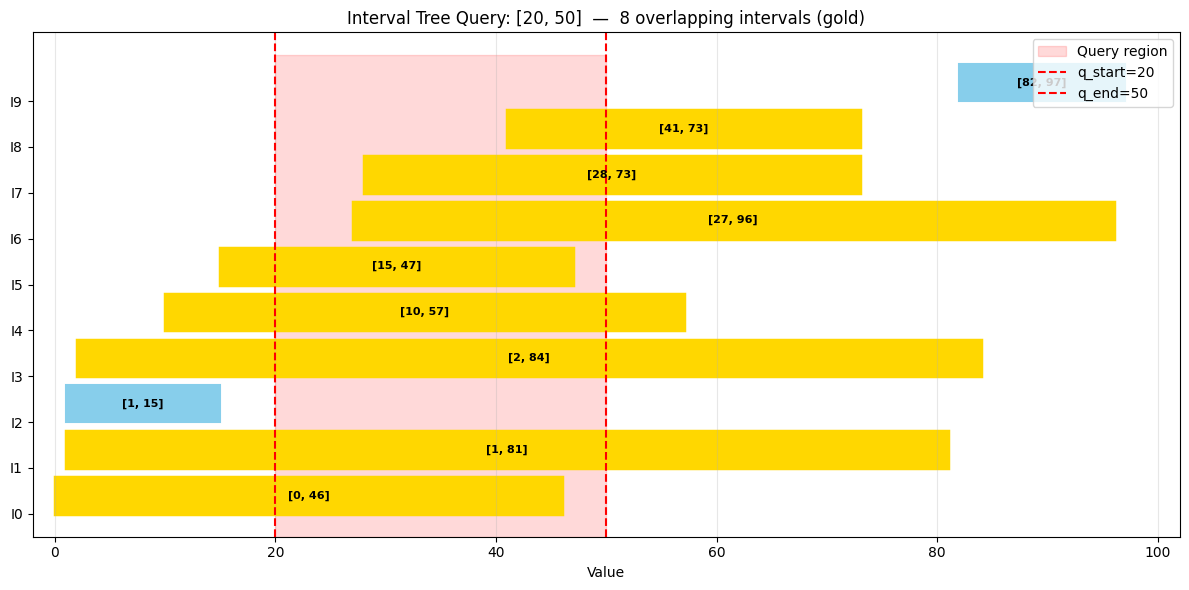

In [18]:
# Query visualization with highlighted overlapping intervals
fig, ax = plt.subplots(figsize=(12, 6))

# Draw query region
query_patch = patches.Rectangle((query[0], -0.5), query[1] - query[0],
                                 len(intervals) + 0.5, color='red', alpha=0.15, label='Query region')
ax.add_patch(query_patch)

# Draw all sorted intervals, highlight overlapping ones
overlap_set = [tuple(iv) for iv in overlapping_intervals]
for i, (start, end) in enumerate(intervals):
    is_overlap = tuple([start, end]) in overlap_set
    color = '#FFD700' if is_overlap else 'skyblue'
    ec = 'darkorange' if is_overlap else 'steelblue'
    lw = 2.5 if is_overlap else 1.5
    ax.add_patch(patches.Rectangle((start, i), end - start, 0.8,
                                    color=color, edgecolor=ec, linewidth=lw))
    ax.text((start + end) / 2, i + 0.4, f'[{start}, {end}]',
            ha='center', va='center', fontsize=8, fontweight='bold')

# Query boundary lines
ax.axvline(x=query[0], color='red', linestyle='--', linewidth=1.5, label=f'q_start={query[0]}')
ax.axvline(x=query[1], color='red', linestyle='--', linewidth=1.5, label=f'q_end={query[1]}')

ax.set_xlim(-2, 102)
ax.set_ylim(-0.5, len(intervals) + 0.5)
ax.set_yticks(range(len(intervals)))
ax.set_yticklabels([f'I{i}' for i in range(len(intervals))])
ax.set_xlabel('Value')
ax.set_title(f'Interval Tree Query: [{query[0]}, {query[1]}]  —  {len(overlapping_intervals)} overlapping intervals (gold)')
ax.legend(loc='upper right')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()